In [1]:
import torch
    
from sns_toolbox.connections import NonSpikingPatternConnection
from sns_toolbox.networks import Network
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sys

from conductance_network import GsynModule, ConductanceLayerMulti, ConductanceNetwork

(-0.5, 31.5, 31.5, -0.5)

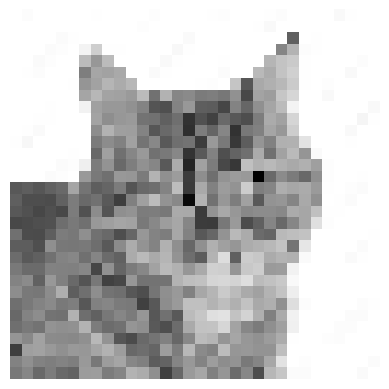

In [2]:
#dirname = os.path.dirname(__file__)
#filename = os.path.join(dirname, 'relative/path/to/file/you/want')

img = cv.imread('cat_example.jpg')   # load image file

if img is None:
    sys.exit('Could not find image')
shape_original = img.shape  # dimensions of the original image
dim_long = max(shape_original[0],shape_original[1]) # longest dimension of the original image
dim_desired_max = 32    # constrain the longest dimension for easier processing
ratio = dim_desired_max/dim_long    # scaling ratio of original image
img_resized = cv.resize(img,None,fx=ratio,fy=ratio) # scale original image using ratio

img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # transform the image from BGR to RGB
img_color_resized = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)  # resize the RGB image
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)  # convert the resized image to grayscale [0-255]

shape = img_gray.shape  # dimensions of the resized grayscale image

img_flat = img_gray.flatten()   # flatten the image into 1 vector for neural processing
flat_size = len(img_flat)   # length of the flattened image vector

plt.figure()
plt.imshow(img_gray,cmap='gray')
plt.axis('off')

## Making the SNS Toolbox Model

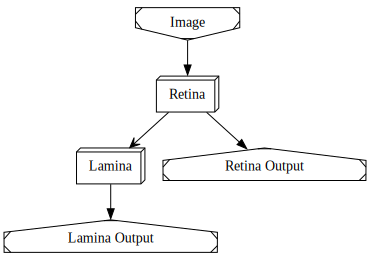

In [3]:
# General network
R = 20.0    # range of network activity (mV)
neuron_type = NonSpikingNeuron()    # generic neuron type
net = Network(name='Visual Network')    # create an empty network

# Retina
net.add_population(neuron_type,shape,name='Retina') # add a 2d population the same size as the scaled image
net.add_input('Retina', size=flat_size,name='Image')    # add a vector input for the flattened scaled image
net.add_output('Retina',name='Retina Output')  # add a vector output from the retina, scaled correctly

# Lamina
net.add_population(neuron_type,shape,name='Lamina')

del_e_ex = 160.0    # excitatory reversal potential
del_e_in = -80.0    # inhibitory reversal potential
k_ex = 1.0  # excitatory gain
k_in = -1.0/9.0 # inhibitory gain
g_max_ex = (k_ex*R)/(del_e_ex-k_ex*R)   # calculate excitatory conductance
g_max_in = (k_in*R)/(del_e_in-k_in*R)   # calculate inhibitory conductance

g_max_kernel = np.array([[g_max_in, g_max_in, g_max_in],    # kernel matrix of synaptic conductances
                         [g_max_in, g_max_ex, g_max_in],
                         [g_max_in, g_max_in, g_max_in]])
del_e_kernel = np.array([[del_e_in, del_e_in, del_e_in],    # kernel matrix of synaptic reversal potentials
                         [del_e_in, del_e_ex, del_e_in],
                         [del_e_in, del_e_in, del_e_in]])
e_lo_kernel = np.zeros([3,3])
e_hi_kernel = np.zeros([3,3]) + R
connection_hpf = NonSpikingPatternConnection(g_max_kernel,del_e_kernel,e_lo_kernel,e_hi_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_hpf,'Retina','Lamina',name='HPF') # connect the retina to the lamina
net.add_output('Lamina',name='Lamina Output')  # add a vector output from the lamina

img_flat = img_flat*R/255.0 # scale all the intensities from 0-255 to 0-R
render(net)

In [6]:
comp = net.compile(dt=0.01,backend='torch')

In [8]:
comp.c_m.shape

torch.Size([2048])

In [14]:
# New ConductanceNetwork Construction
dt = torch.ones(shape[0], dtype=torch.double)
C_mem = torch.rand(shape[0], dtype=torch.double)
G_mem = torch.rand(shape[0], dtype=torch.double)
b_mem = torch.rand(shape[0], dtype=torch.double)
Esyn = torch.randn(shape, dtype=torch.double)

# Retina layer
retina_layer = ConductanceLayerMulti(n_prev=flat_size, n=flat_size, dt=dt, C_mem=C_mem, G_mem=G_mem, b_mem=b_mem, Esyn_self=Esyn, is_first=True)

# Lamina layer
lamina_layer = ConductanceLayerMulti(n_prev=flat_size, n=flat_size, dt=dt, C_mem=C_mem, G_mem=G_mem, b_mem=b_mem, Esyn_self=Esyn)

# Construct the ConductanceNetwork
layers = [retina_layer, lamina_layer]
network = ConductanceNetwork(layers)